## N-gram language model

In [5]:
import re
import math
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import logging
import time
import random
import os

class NGramModel:
    """
    N-gram語言模型實現
    支援 n=2 (bigram) 和 n=3 (trigram)
    """
    
    def __init__(self, n: int = 2):
        """
        初始化N-gram模型
        
        Args:
            n (int): n-gram的階數 (2 for bigram, 3 for trigram)
        """
        self.n = n
        self.ngram_counts = defaultdict(int)  # n-gram計數
        self.context_counts = defaultdict(int)  # (n-1)-gram計數
        self.vocabulary = set()  # 詞彙表
        self.total_words = 0
        
        # 特殊符號
        self.start_token = "<s>"
        self.end_token = "</s>"
        self.unk_token = "<unk>"
    
    def preprocess_text(self, text: str) -> List[str]:
        """
        文本預處理
        
        Args:
            text (str): 原始文本
            
        Returns:
            List[str]: 處理後的詞列表
        """
        # 轉小寫，保留字母、數字和基本標點
        text = text.lower()
        # 用正則表達式分詞
        words = re.findall(r'\b\w+\b|[.!?]', text)
        return words
    
    def add_sentence_markers(self, words: List[str]) -> List[str]:
        """
        為句子添加開始和結束標記
        
        Args:
            words (List[str]): 詞列表
            
        Returns:
            List[str]: 添加標記後的詞列表
        """
        # 根據n-gram階數添加適當數量的開始標記
        start_markers = [self.start_token] * (self.n - 1)
        return start_markers + words + [self.end_token]
    
    def get_ngrams(self, words: List[str]) -> List[Tuple[str, ...]]:
        """
        從詞列表生成n-gram
        
        Args:
            words (List[str]): 詞列表
            
        Returns:
            List[Tuple[str, ...]]: n-gram列表
        """
        ngrams = []
        for i in range(len(words) - self.n + 1):
            ngram = tuple(words[i:i + self.n])
            ngrams.append(ngram)
        return ngrams
    
    def get_contexts(self, words: List[str]) -> List[Tuple[str, ...]]:
        """
        從詞列表生成context (n-1)-gram
        
        Args:
            words (List[str]): 詞列表
            
        Returns:
            List[Tuple[str, ...]]: context列表
        """
        contexts = []
        for i in range(len(words) - self.n + 1):
            context = tuple(words[i:i + self.n - 1])
            contexts.append(context)
        return contexts
    
    def train(self, train_file: str):
        """
        訓練N-gram模型
        
        Args:
            train_file (str): 訓練文件路徑
        """
        print(f"Start training {self.n}-gram model...")
        
        line_count = 0
        with open(train_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                # 預處理文本
                words = self.preprocess_text(line)
                if len(words) == 0:
                    continue
                
                # 添加句子標記
                words_with_markers = self.add_sentence_markers(words)
                
                # 更新詞彙表
                self.vocabulary.update(words)
                self.total_words += len(words)
                
                # 生成n-gram和context
                ngrams = self.get_ngrams(words_with_markers)
                contexts = self.get_contexts(words_with_markers)
                
                # 更新計數
                for ngram in ngrams:
                    self.ngram_counts[ngram] += 1
                
                for context in contexts:
                    self.context_counts[context] += 1

        print(f"Training completed!")
        print(f"Total words: {self.total_words}")
        print(f"Vocabulary size: {len(self.vocabulary)}")
        print(f"N-gram total: {len(self.ngram_counts)}")
        print(f"Context total: {len(self.context_counts)}")

    def get_probability(self, ngram: Tuple[str, ...]) -> float:
        """
        計算n-gram的條件概率
        使用最大似然估計 (MLE)
        
        Args:
            ngram (Tuple[str, ...]): n-gram
            
        Returns:
            float: 條件概率
        """
        if len(ngram) != self.n:
            raise ValueError(f"N-gram長度應為 {self.n}")
        
        # 取得context
        context = ngram[:-1]
        
        # 處理未見過的context
        if self.context_counts[context] == 0:
            return 1e-10  # 平滑處理，避免概率為0
        
        # P(w_n | w_1, ..., w_{n-1}) = Count(w_1, ..., w_n) / Count(w_1, ..., w_{n-1})
        return self.ngram_counts[ngram] / self.context_counts[context]
    
    def get_sentence_probability(self, sentence: str) -> float:
        """
        計算句子的概率
        
        Args:
            sentence (str): 句子
            
        Returns:
            float: 句子概率的對數值
        """
        words = self.preprocess_text(sentence)
        if len(words) == 0:
            return float('-inf')
        
        words_with_markers = self.add_sentence_markers(words)
        ngrams = self.get_ngrams(words_with_markers)
        
        log_prob = 0.0
        for ngram in ngrams:
            prob = self.get_probability(ngram)
            if prob > 0:
                log_prob += math.log(prob)
            else:
                log_prob += math.log(1e-10)  # 平滑處理
        
        return log_prob
    
    def calculate_perplexity(self, test_file: str) -> float:
        """
        計算測試集的困惑度 (perplexity)
        
        Args:
            test_file (str): 測試文件路徑
            
        Returns:
            float: 困惑度值
        """
        print(f"Calculating {self.n}-gram model perplexity...")
        
        total_log_prob = 0.0
        total_words = 0
        line_count = 0
        
        with open(test_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                words = self.preprocess_text(line)
                if len(words) == 0:
                    continue
                
                # 計算句子概率
                log_prob = self.get_sentence_probability(line)
                total_log_prob += log_prob
                total_words += len(words)
                
        
        # 計算困惑度: PP = exp(-1/N * sum(log P(sentence)))
        avg_log_prob = total_log_prob / total_words
        perplexity = math.exp(-avg_log_prob)
        
        print(f"測試集總詞數: {total_words}")
        print(f"平均對數概率: {avg_log_prob:.6f}")
        print(f"{self.n}-gram 困惑度: {perplexity:.2f}")
        
        return perplexity
    
    def calculate_accuracy(self, test_file: str) -> float:
        """
        計算測試集的準確率 (accuracy)
        預測下一個詞的準確率
        
        Args:
            test_file (str): 測試文件路徑
            
        Returns:
            float: 準確率值 (0-1)
        """
        print(f"Calculating {self.n}-gram model accuracy...")
        
        correct_predictions = 0
        total_predictions = 0
        
        with open(test_file, 'r', encoding='utf-8') as f:
            count = 0
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                words = self.preprocess_text(line)
                if len(words) < self.n:
                    continue
                
                # 添加句子標記
                words_with_markers = self.add_sentence_markers(words)
                
                # 對每個可能的 n-gram 進行預測
                for i in range(self.n - 1, len(words_with_markers)):
                    count += 1
                    if count > 50:  # 每行最多預測50次
                        break
                    # 取得 context (前 n-1 個詞)
                    context = tuple(words_with_markers[i - self.n + 1:i])
                    # 實際的下一個詞
                    actual_word = words_with_markers[i]

                    # 預測下一個詞 (選擇概率最高的詞)
                    predicted_word = self.predict_next_word(context)
                    
                    if predicted_word == actual_word:
                        correct_predictions += 1
                    total_predictions += 1
                
        accuracy = correct_predictions / total_predictions
        
        print(f"正確預測數: {correct_predictions}")
        print(f"總預測數: {total_predictions}")
        print(f"{self.n}-gram 準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        return accuracy
    
    def predict_next_word(self, context: Tuple[str, ...]) -> str:
        """
        根據給定的 context 預測下一個最可能的詞
        
        Args:
            context (Tuple[str, ...]): 上下文
            
        Returns:
            str: 預測的下一個詞
        """
        if len(context) != self.n - 1:
            raise ValueError(f"Context 長度應為 {self.n - 1}")
        
        # 找出所有以此 context 開始的 n-gram
        candidate_ngrams = []
        for ngram in self.ngram_counts:
            if ngram[:-1] == context:
                probability = self.get_probability(ngram)
                candidate_ngrams.append((ngram[-1], probability))
        
        if not candidate_ngrams:
            # 如果沒有找到匹配的 n-gram，返回未知詞標記
            return self.unk_token
        
        # 選擇概率最高的詞
        best_word = max(candidate_ngrams, key=lambda x: x[1])[0]
        return best_word
    
    def generate_text(self, context: Tuple[str, ...], max_length: int = 20) -> str:
        """
        基於給定context生成文本
        
        Args:
            context (Tuple[str, ...]): 初始context
            max_length (int): 最大生成長度
            
        Returns:
            str: 生成的文本
        """
        if len(context) != self.n - 1:
            raise ValueError(f"Context長度應為 {self.n - 1}")
        
        result = list(context)
        current_context = context
        
        for _ in range(max_length):
            # 找到所有以current_context開頭的n-gram
            candidates = []
            for ngram, count in self.ngram_counts.items():
                if ngram[:-1] == current_context:
                    candidates.extend([ngram[-1]] * count)

            if not candidates:
                break  # 無法繼續生成
            
            # 移除結束標記
            candidates = [word for word in candidates if word != self.end_token]

            # 隨機選擇下一個詞
            next_word = random.choice(candidates)
            
            result.append(next_word)
            # 更新context
            current_context = tuple(result[-(self.n-1):])
        
        # 移除開始標記
        filtered_result = [word for word in result if word != self.start_token]
        return ' '.join(filtered_result)

## N-gram training

In [27]:
"""
N-gram語言模型訓練和測試程式
使用 train.txt 訓練模型，在 test.txt 上評估性能
比較 n=2 (bigram) 和 n=3 (trigram) 的表現
"""

train_file = "data/train.txt"
test_file = "data/test.txt"

print("=" * 60)
print("N-gram model Training and Evaluation")
print("=" * 60)

results = {}
trained_models = {}  # Store trained models for text generation

for n in [2, 3]:
    print(f"\n{'='*20} N={n} ({'Bigram' if n==2 else 'Trigram'}) {'='*20}")
    
    start_time = time.time()

    model = NGramModel(n=n)

    print(f"Train {n}-gram model...")
    model.train(train_file)
    
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Calculate perplexity and accuracy
    start_time = time.time()
    perplexity = model.calculate_perplexity(test_file)
    accuracy = model.calculate_accuracy(test_file)
    test_time = time.time() - start_time

    print(f"Testing time: {test_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # save results and model
    results[n] = {
        'perplexity': perplexity,
        'accuracy': accuracy,
        'training_time': training_time,
        'test_time': test_time,
        'vocab_size': len(model.vocabulary),
        'total_words': model.total_words,
        'ngram_types': len(model.ngram_counts),
        'context_types': len(model.context_counts)
    }
    trained_models[n] = model  # Store the trained model

    print(f"\n{n}-gram model text generation examples:")
    try:
        if n == 2:
            contexts = [("add",), ("cook",), ("bake",)]
        else:
            contexts = [("add", "the"), ("cook", "for"), ("bake", "at")]
        
        for context in contexts:
            generated = model.generate_text(context, max_length=15)
            print(f"  Context: {' '.join(context)} -> {generated}")
    except Exception as e:
        print(f"  Error occurred during text generation: {e}")

# Results comparison
print("\n" + "=" * 60)
print("Results Comparison")
print("=" * 60)

print(f"{'Metric':<20} {'Bigram (n=2)':<15} {'Trigram (n=3)':<15} {'Difference':<15}")
print("-" * 65)

bigram_pp = results[2]['perplexity']
trigram_pp = results[3]['perplexity']
pp_diff = ((trigram_pp - bigram_pp) / bigram_pp) * 100

print(f"{'Perplexity':<20} {bigram_pp:<15.2f} {trigram_pp:<15.2f} {pp_diff:+.2f}%")

bigram_acc = results[2]['accuracy']
trigram_acc = results[3]['accuracy']
acc_diff = ((trigram_acc - bigram_acc) / bigram_acc) * 100

print(f"{'Accuracy':<20} {bigram_acc:<15.4f} {trigram_acc:<15.4f} {acc_diff:+.2f}%")

bigram_time = results[2]['training_time']
trigram_time = results[3]['training_time']
time_diff = ((trigram_time - bigram_time) / bigram_time) * 100

print(f"{'Training time':<20} {bigram_time:<15.2f} {trigram_time:<15.2f} {time_diff:+.2f}%")

bigram_ngrams = results[2]['ngram_types']  
trigram_ngrams = results[3]['ngram_types']
ngram_diff = ((trigram_ngrams - bigram_ngrams) / bigram_ngrams) * 100

print(f"{'N-gram types':<20} {bigram_ngrams:<15,} {trigram_ngrams:<15,} {ngram_diff:+.2f}%")

print(f"{'Vocabulary size':<20} {results[2]['vocab_size']:<15,} {results[3]['vocab_size']:<15,} {'Same':<15}")
print(f"{'Total words':<20} {results[2]['total_words']:<15,} {results[3]['total_words']:<15,} {'Same':<15}")

N-gram model Training and Evaluation

==================== N=2 (Bigram) ====================
Train 2-gram model...
Start training 2-gram model...
Training completed!
Total words: 17728510
Vocabulary size: 38404
N-gram total: 660108
Context total: 38405
Training time: 12.12 seconds
Calculating 2-gram model perplexity...
測試集總詞數: 4420449
平均對數概率: -4.562487
2-gram 困惑度: 95.82
Calculating 2-gram model accuracy...
正確預測數: 15
總預測數: 50
2-gram 準確率: 0.3000 (30.00%)
Testing time: 5.64 seconds
Accuracy: 0.3000 (30.00%)

2-gram model text generation examples:
  Context: add -> add onion and secure with the yoghurt and next grab 1 hour and add remaining ingredients
  Context: cook -> cook fettuccini in a food colouring and almond extract in slightly thicken for 10 min or
  Context: bake -> bake in whipped cream cheese or plate in a full the pumpkin pie shell and bring

==================== N=3 (Trigram) ====================
Train 3-gram model...
Start training 3-gram model...
Training completed!
Total 

### Question: Use n= 2 and n= 3 to calculate bigrams and trigrams, respectively, and evaluatethe test accuracy in test.txt and make some discussion.
Answer:

### Question: Please observe the hardware usage in your computer while the models are running and make some discussion.

Answer: When training the 2-gram model, the process only took about 1.0% of memory, while on the other hand, 3-gram model need 5.7% of memory. The reason is probably because 3-gram model has much more N-gram types

## Complete the incomplete.txt

In [28]:
# Test with incomplete.txt for text completion
with open("data/incomplete.txt", "r", encoding="utf-8") as f:
    incomplete_lines = [line.strip() for line in f if line.strip()]

for i, incomplete_text in enumerate(incomplete_lines):
    words = model.preprocess_text(incomplete_text)
    context = (words[-2], words[-1])
    # Generate completion
    completion = model.generate_text(context, max_length=20)
    # Remove the context words from completion to show only new words
    context_str = ' '.join(context)
    new_words = completion[len(context_str):].strip()    
    full_completion = incomplete_text + " " + new_words
    print(f"  '{incomplete_text}' -> '{full_completion}'")

  'cover with' -> 'cover with aluminum foil and continue to set them on the pot to high and are ready to serve this with frozen'
  'roll up' -> 'roll up a day ahead and kept chilled in an 8x11 inch baking pan with cooking spray in an oven tray brushed'
  'cook the' -> 'cook the spinach mixture over dough rectangles with cheese and mint along the edge of the pan so nothing gets cold !'
  'stir in' -> 'stir in creamed mixture just enough to handle the dough from greased slotted spoon to scrape out the insides into a greased'
  'spread out' -> 'spread out on flat ends on kitchen paper and butter until creamy and soft scrambled eggs into the center comes out clean'
  'transfer the' -> 'transfer the pan with parchment paper or in a smaller bowl combine flour with a fork slightly puncture the peppers to a'
  'put the' -> 'put the cheese melts and sugar on the rim of the ricotta mix on high until sugar is dissolved and the onions'
  'push the' -> 'push the batter will be thick enough to maint

# RNN and LSTM model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
from collections import Counter, defaultdict
import time
from typing import List, Tuple, Dict
import os
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

## Vocabulary and TextDataset

In [17]:
class Vocabulary:
    """詞彙表類別，處理詞彙到索引的轉換"""
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = Counter()
        
        # 特殊標記
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.start_token = '<START>'
        self.end_token = '<END>'
        
        # 初始化特殊標記
        self.add_word(self.pad_token)
        self.add_word(self.unk_token)
        self.add_word(self.start_token)
        self.add_word(self.end_token)
        
    def add_word(self, word: str) -> int:
        """添加詞彙到詞彙表"""
        if word not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
        self.word_count[word] += 1
        return self.word2idx[word]
    
    def build_vocab(self, texts: List[str], min_freq: int = 2):
        """建立詞彙表"""
        print("Building vocabulary...")
        
        # 統計詞頻
        for text in texts:
            words = self.preprocess_text(text)
            for word in words:
                self.word_count[word] += 1
        
        # 添加高頻詞到詞彙表
        for word, count in self.word_count.items():
            if count >= min_freq and word not in self.word2idx:
                self.add_word(word)
        
        print(f"Vocabulary size: {len(self.word2idx)}")
        print(f"Most common words: {self.word_count.most_common(10)}")
    
    def preprocess_text(self, text: str) -> List[str]:
        """文本預處理"""
        text = text.lower().strip()
        words = re.findall(r'\b\w+\b', text)
        return words
    
    def text_to_indices(self, text: str) -> List[int]:
        """將文本轉換為索引序列"""
        words = self.preprocess_text(text)
        indices = [self.word2idx[self.start_token]]
        
        for word in words:
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx[self.unk_token])
        
        indices.append(self.word2idx[self.end_token])
        return indices
    
    def indices_to_text(self, indices: List[int]) -> str:
        """將索引序列轉換為文本"""
        words = []
        for idx in indices:
            if idx in self.idx2word:
                word = self.idx2word[idx]
                if word not in [self.pad_token, self.start_token, self.end_token]:
                    words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    """文本數據集類別"""
    
    def __init__(self, texts: List[str], vocab: Vocabulary, seq_length: int = 10):
        self.vocab = vocab
        self.seq_length = seq_length
        self.sequences = []
        
        self.prepare_sequences(texts)
    
    def prepare_sequences(self, texts: List[str]):
        """準備訓練序列"""
        print("Preparing training sequences...")
        
        for text in texts:
            indices = self.vocab.text_to_indices(text)
            
            # 如果序列太短，跳過
            if len(indices) < 2:
                continue

            # 限制總 sequence 數量
            if len(self.sequences) >= 10000:
                break
            
            # 創建滑動窗口序列
            for i in range(len(indices) - 1):
                # 輸入序列和目標序列
                input_seq = indices[max(0, i - self.seq_length + 1):i + 1]
                target = indices[i + 1]
                
                # 填充到固定長度
                if len(input_seq) < self.seq_length:
                    padding = [self.vocab.word2idx[self.vocab.pad_token]] * (self.seq_length - len(input_seq))
                    input_seq = padding + input_seq
                
                self.sequences.append((input_seq, target))
        
        print(f"Created {len(self.sequences)} training sequences")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq, target = self.sequences[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

## RNN LanguageModel and Trainer

In [24]:
class RNNLanguageModel(nn.Module):
    """RNN 語言模型"""
    
    def __init__(self, vocab_size: int, embed_dim: int = 128, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super(RNNLanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 詞嵌入層
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # RNN 層
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, 
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Dropout 層
        self.dropout = nn.Dropout(dropout)
        
        # 輸出層
        self.linear = nn.Linear(hidden_dim, vocab_size)
        
        # 初始化權重
        self.init_weights()
    
    def init_weights(self):
        """初始化模型權重"""
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-init_range, init_range)
    
    def forward(self, x, hidden=None):
        """前向傳播"""
        batch_size = x.size(0)
        
        # 詞嵌入
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        
        # RNN
        rnn_out, hidden = self.rnn(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        
        # 取最後一個時間步的輸出
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # Dropout
        output = self.dropout(last_output)
        
        # 線性層
        output = self.linear(output)  # (batch_size, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        """初始化隱藏狀態"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

class RNNTrainer:
    """RNN 訓練器"""
    
    def __init__(self, model, vocab, device, learning_rate: float = 0.001):
        self.model = model
        self.vocab = vocab
        self.device = device
        
        # 損失函數和優化器
        self.criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # 追蹤訓練歷史
        self.train_losses = []
        self.train_accuracies = []
        
    def train_epoch(self, dataloader):
        """訓練一個 epoch"""
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        # 創建 tqdm 進度條
        pbar = tqdm(dataloader, desc="Training", leave=False)
        
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)
            batch_size = data.size(0)
            
            # 初始化隱藏狀態
            hidden = self.model.init_hidden(batch_size, self.device)
            
            # 前向傳播
            outputs, _ = self.model(data, hidden)
            loss = self.criterion(outputs, targets)
            
            # 計算準確率
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == targets).sum().item()
            
            # 反向傳播
            self.optimizer.zero_grad()
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            
            self.optimizer.step()
            
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # 更新進度條
            current_loss = total_loss / total_samples
            current_acc = correct_predictions / total_samples
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
        
        return avg_loss, accuracy
    
    def evaluate(self, dataloader):
        """評估模型"""
        self.model.eval()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        # 創建 tqdm 進度條用於評估
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        
        with torch.no_grad():
            for data, targets in pbar:
                data, targets = data.to(self.device), targets.to(self.device)
                batch_size = data.size(0)
                
                hidden = self.model.init_hidden(batch_size, self.device)
                outputs, _ = self.model(data, hidden)
                loss = self.criterion(outputs, targets)
                
                # 計算準確率
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == targets).sum().item()
                
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                # 更新進度條
                current_loss = total_loss / total_samples
                current_acc = correct_predictions / total_samples
                pbar.set_postfix({
                    'Loss': f'{current_loss:.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        perplexity = math.exp(avg_loss)
        
        return avg_loss, accuracy, perplexity
    
    def generate_text(self, start_text: str, max_length: int = 10, temperature: float = 1.0):
        """生成文本"""
        self.model.eval()
        
        # 預處理起始文本
        indices = self.vocab.text_to_indices(start_text)
        if len(indices) == 0:
            indices = [self.vocab.word2idx[self.vocab.start_token]]
        
        generated = indices.copy()
        
        with torch.no_grad():
            for _ in range(max_length):
                # 準備輸入序列
                input_seq = generated[-10:]  # 取最後10個詞作為上下文
                if len(input_seq) < 10:
                    padding = [self.vocab.word2idx[self.vocab.pad_token]] * (10 - len(input_seq))
                    input_seq = padding + input_seq
                
                input_tensor = torch.tensor([input_seq], dtype=torch.long).to(self.device)
                hidden = self.model.init_hidden(1, self.device)

                # 預測下一個詞
                outputs, _ = self.model(input_tensor, hidden)
                outputs = outputs / temperature
                probabilities = torch.softmax(outputs, dim=-1)
                
                # 隨機採樣
                next_word_idx = torch.multinomial(probabilities, 1).item()
                
                # 如果生成結束標記，停止生成
                # if next_word_idx == self.vocab.word2idx[self.vocab.end_token]:
                #     break

                generated.append(next_word_idx)
        
        print(generated)
        return self.vocab.indices_to_text(generated)
    
    def plot_learning_curves(self, save_path='rnn_learning_curves.png'):
        """繪製學習曲線"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # 繪製訓練損失
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.set_title('Training Loss Curve')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # 繪製訓練準確率
        ax2.plot(epochs, self.train_accuracies, 'r-', label='Training Accuracy')
        ax2.set_title('Training Accuracy Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Learning curves saved to {save_path}")

## LSTM Language Model and Trainer

In [ ]:
class LSTMLanguageModel(nn.Module):
    """LSTM 語言模型"""
    
    def __init__(self, vocab_size: int, embed_dim: int = 128, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super(LSTMLanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 詞嵌入層
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM 層
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Dropout 層
        self.dropout = nn.Dropout(dropout)
        
        # 輸出層
        self.linear = nn.Linear(hidden_dim, vocab_size)
        
        # 初始化權重
        self.init_weights()
    
    def init_weights(self):
        """初始化模型權重"""
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-init_range, init_range)
    
    def forward(self, x, hidden=None):
        """前向傳播"""
        batch_size = x.size(0)
        
        # 詞嵌入
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        
        # LSTM
        lstm_out, hidden = self.lstm(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        
        # 取最後一個時間步的輸出
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # Dropout
        output = self.dropout(last_output)
        
        # 線性層
        output = self.linear(output)  # (batch_size, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        """初始化隱藏狀態和細胞狀態"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

class LSTMTrainer:
    """LSTM 訓練器"""
    
    def __init__(self, model, vocab, device):
        self.model = model
        self.vocab = vocab
        self.device = device
        
        # 損失函數和優化器
        self.criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 追蹤訓練歷史
        self.train_losses = []
        self.train_accuracies = []
        
    def train_epoch(self, dataloader):
        """訓練一個 epoch"""
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        # 創建 tqdm 進度條
        pbar = tqdm(dataloader, desc="Training", leave=False)
        
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)
            batch_size = data.size(0)
            
            # 初始化隱藏狀態
            hidden = self.model.init_hidden(batch_size, self.device)
            
            # 前向傳播
            outputs, _ = self.model(data, hidden)
            loss = self.criterion(outputs, targets)
            
            # 計算準確率
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == targets).sum().item()
            
            # 反向傳播
            self.optimizer.zero_grad()
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            
            self.optimizer.step()
            
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # 更新進度條
            current_loss = total_loss / total_samples
            current_acc = correct_predictions / total_samples
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        
        # 記錄訓練歷史
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
        
        return avg_loss, accuracy
    
    def evaluate(self, dataloader):
        """評估模型"""
        self.model.eval()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        # 創建 tqdm 進度條用於評估
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        
        with torch.no_grad():
            for data, targets in pbar:
                data, targets = data.to(self.device), targets.to(self.device)
                batch_size = data.size(0)
                
                hidden = self.model.init_hidden(batch_size, self.device)
                outputs, _ = self.model(data, hidden)
                loss = self.criterion(outputs, targets)
                
                # 計算準確率
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == targets).sum().item()
                
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                # 更新進度條
                current_loss = total_loss / total_samples
                current_acc = correct_predictions / total_samples
                pbar.set_postfix({
                    'Loss': f'{current_loss:.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        perplexity = math.exp(avg_loss)
        
        return avg_loss, accuracy, perplexity
    
    def generate_text(self, start_text: str, max_length: int = 10, temperature: float = 1.0):
        """生成文本"""
        self.model.eval()
        
        # 預處理起始文本
        indices = self.vocab.text_to_indices(start_text)
        if len(indices) == 0:
            indices = [self.vocab.word2idx[self.vocab.start_token]]
        
        generated = indices.copy()
        
        with torch.no_grad():
            for _ in range(max_length):
                # 準備輸入序列
                input_seq = generated[-10:]  # 取最後10個詞作為上下文
                if len(input_seq) < 10:
                    padding = [self.vocab.word2idx[self.vocab.pad_token]] * (10 - len(input_seq))
                    input_seq = padding + input_seq
                
                input_tensor = torch.tensor([input_seq], dtype=torch.long).to(self.device)
                hidden = self.model.init_hidden(1, self.device)
                
                # 預測下一個詞
                outputs, _ = self.model(input_tensor, hidden)
                outputs = outputs / temperature
                probabilities = torch.softmax(outputs, dim=-1)
                
                # 隨機採樣
                next_word_idx = torch.multinomial(probabilities, 1).item()
                
                # 如果生成結束標記，停止生成
                if next_word_idx == self.vocab.word2idx[self.vocab.end_token]:
                    break
                
                generated.append(next_word_idx)
        
        return self.vocab.indices_to_text(generated)
    
    def plot_learning_curves(self, save_path='lstm_learning_curves.png'):
        """繪製學習曲線"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # 繪製訓練損失
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.set_title('LSTM Training Loss Curve')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # 繪製訓練準確率
        ax2.plot(epochs, self.train_accuracies, 'r-', label='Training Accuracy')
        ax2.set_title('LSTM Training Accuracy Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Learning curves saved to {save_path}")

## utils

In [19]:
def load_data(file_path: str) -> List[str]:
    """載入訓練數據"""
    texts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                texts.append(line)
    
    print(f"Loaded {len(texts)} texts from {file_path}")
    return texts

def evaluate_on_test_data(trainer, vocab, test_file: str, seq_length: int = 10, batch_size: int = 32):
    """在測試數據上評估模型"""
    print(f"Evaluating model on {test_file}...")
    
    # 載入測試數據
    test_texts = load_data(test_file)
    if not test_texts:
        return
    
    # 創建測試數據集
    test_dataset = TextDataset(test_texts, vocab, seq_length)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 評估模型
    test_loss, test_accuracy, test_perplexity = trainer.evaluate(test_dataloader)
    
    print("\n" + "="*60)
    print("RNN 模型測試結果")
    print("="*60)
    print(f"測試損失 (Test Loss): {test_loss:.4f}")
    print(f"測試準確率 (Test Accuracy): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"測試困惑度 (Test Perplexity): {test_perplexity:.4f}")
    print("="*60)
    
    return test_loss, test_accuracy, test_perplexity

def test_incomplete_sentences(trainer, incomplete_file: str):
    """測試不完整句子的補全"""
    print("Testing incomplete sentence completion...")
    
    with open(incomplete_file, 'r', encoding='utf-8') as f:
        incomplete_texts = [line.strip() for line in f if line.strip()]
    
    print("\n" + "="*60)
    print("RNN 模型文本補全結果")
    print("="*60)
    
    for incomplete_text in incomplete_texts:
        completed = trainer.generate_text(incomplete_text, max_length=20, temperature=0.8)
        print(f"輸入: {incomplete_text}")
        print(f"補全: {completed}")
        print("-" * 50)

## RNN Training

Using device: cuda
Loaded 2599668 texts from data/train.txt
Building vocabulary...
Vocabulary size: 15843
Most common words: [('and', 910902), ('the', 851351), ('in', 479094), ('a', 463682), ('to', 460822), ('with', 307128), ('until', 276529), ('add', 252377), ('minutes', 233439), ('of', 231635)]
Preparing training sequences...
Created 10004 training sequences
Model parameters: 4,137,699
Starting training...


RNN Training Progress:  10%|█         | 1/10 [00:02<00:24,  2.77s/it, Loss=6.3985, Acc=0.1194, Time=2.8s]

Epoch 1/10, Train Loss: 6.3985, Train Accuracy: 0.1194, Time: 2.77s


RNN Training Progress:  20%|██        | 2/10 [00:05<00:21,  2.66s/it, Loss=5.4147, Acc=0.1539, Time=2.6s]

Epoch 2/10, Train Loss: 5.4147, Train Accuracy: 0.1539, Time: 2.59s


RNN Training Progress:  30%|███       | 3/10 [00:11<00:29,  4.28s/it, Loss=4.9471, Acc=0.1854, Time=6.2s]

Epoch 3/10, Train Loss: 4.9471, Train Accuracy: 0.1854, Time: 6.20s


RNN Training Progress:  40%|████      | 4/10 [00:14<00:21,  3.66s/it, Loss=4.6088, Acc=0.2100, Time=2.7s]

Epoch 4/10, Train Loss: 4.6088, Train Accuracy: 0.2100, Time: 2.70s


RNN Training Progress:  50%|█████     | 5/10 [00:16<00:16,  3.31s/it, Loss=4.3118, Acc=0.2243, Time=2.7s]

Epoch 5/10, Train Loss: 4.3118, Train Accuracy: 0.2243, Time: 2.70s


RNN Training Progress:  60%|██████    | 6/10 [00:19<00:12,  3.12s/it, Loss=4.0594, Acc=0.2492, Time=2.7s]

Epoch 6/10, Train Loss: 4.0594, Train Accuracy: 0.2492, Time: 2.74s


RNN Training Progress:  70%|███████   | 7/10 [00:22<00:09,  3.01s/it, Loss=3.8207, Acc=0.2695, Time=2.8s]

Epoch 7/10, Train Loss: 3.8207, Train Accuracy: 0.2695, Time: 2.78s


RNN Training Progress:  80%|████████  | 8/10 [00:25<00:05,  2.96s/it, Loss=3.6132, Acc=0.2892, Time=2.9s]

Epoch 8/10, Train Loss: 3.6132, Train Accuracy: 0.2892, Time: 2.85s


RNN Training Progress:  90%|█████████ | 9/10 [00:28<00:02,  2.92s/it, Loss=3.4198, Acc=0.3132, Time=2.8s]

Epoch 9/10, Train Loss: 3.4198, Train Accuracy: 0.3132, Time: 2.83s


RNN Training Progress: 100%|██████████| 10/10 [00:30<00:00,  3.10s/it, Loss=3.2450, Acc=0.3345, Time=2.8s]


Epoch 10/10, Train Loss: 3.2450, Train Accuracy: 0.3345, Time: 2.81s
Model saved to rnn_model.pth


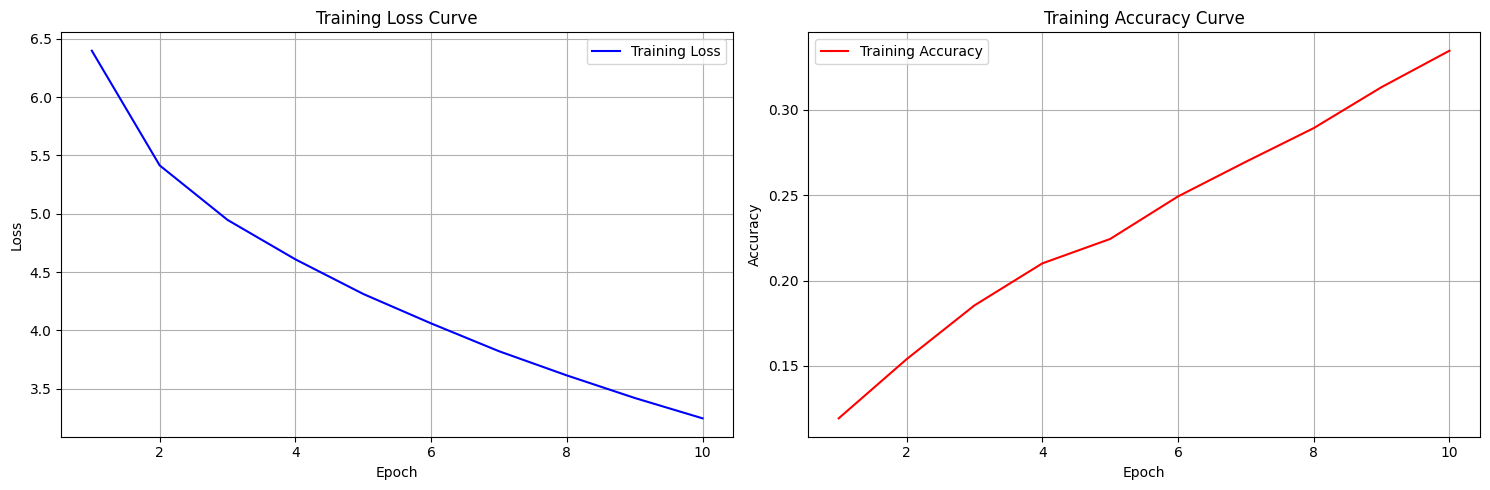

Learning curves saved to rnn_learning_curves.png
Evaluating model on data/test.txt...
Loaded 649918 texts from data/test.txt
Preparing training sequences...
Created 10003 training sequences



RNN 模型測試結果
測試損失 (Test Loss): 5.3370
測試準確率 (Test Accuracy): 0.2119 (21.19%)
測試困惑度 (Test Perplexity): 207.8853
Testing incomplete sentence completion...

RNN 模型文本補全結果
[2, 74, 59, 3, 66, 97, 207, 61, 465, 22, 3, 242, 866, 3, 217, 945, 3, 3, 3, 97, 10, 98, 3, 3]
輸入: cover with
補全: cover with water to onion and baking powder making days over tomatillos to a boil
--------------------------------------------------
[2, 256, 93, 3, 34, 183, 37, 3, 3, 61, 4, 97, 206, 3, 217, 126, 3, 3, 3, 213, 3, 3, 3, 97]
輸入: roll up
補全: roll up in medium bowl and put to taste over bottom cutter to
--------------------------------------------------
[2, 133, 12, 3, 26, 12, 247, 590, 61, 43, 116, 70, 3, 3, 3, 6, 172, 173, 84, 122, 3, 3, 3, 26]
輸入: cook the
補全: cook the until the sure cooking and let 5 minutes on vegetable oil into brown until
--------------------------------------------------
[2, 248, 34, 3, 3, 217, 183, 26, 148, 3, 134, 240, 3, 447, 97, 138, 59, 10, 1109, 3, 3, 3, 8, 26]
輸入: stir in
補全: stir in

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
HIDDEN_DIM = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 32
SEQ_LENGTH = 10

# Load data
train_texts = load_data('data/train.txt')

# Build vocabulary
vocab = Vocabulary()
vocab.build_vocab(train_texts, min_freq=3)

# Create dataset
train_dataset = TextDataset(train_texts, vocab, SEQ_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RNNLanguageModel(
    vocab_size=len(vocab),
    embed_dim=HIDDEN_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# create trainer
trainer = RNNTrainer(model, vocab, device, LEARNING_RATE)

# Training loop
print("Starting training...")

# 創建 epoch 進度條
epoch_pbar = tqdm(range(NUM_EPOCHS), desc="RNN Training Progress")

for epoch in epoch_pbar:
    start_time = time.time()
    
    train_loss, train_accuracy = trainer.train_epoch(train_dataloader)
    
    epoch_time = time.time() - start_time
    
    # 更新 epoch 進度條
    epoch_pbar.set_postfix({
        'Loss': f'{train_loss:.4f}',
        'Acc': f'{train_accuracy:.4f}',
        'Time': f'{epoch_time:.1f}s'
    })
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Time: {epoch_time:.2f}s')

# save model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'hyperparameters': {
        'vocab_size': len(vocab),
        'embed_dim': HIDDEN_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS
    }
}, 'rnn_model.pth')

print("Model saved to rnn_model.pth")

# plot learning curves
trainer.plot_learning_curves('rnn_learning_curves.png')

# evaluate on test data
evaluate_on_test_data(trainer, vocab, 'data/test.txt', SEQ_LENGTH, BATCH_SIZE)

# test incomplete sentences
test_incomplete_sentences(trainer, 'data/incomplete.txt')

## LSTM Training

Using device: cuda
Loaded 2599668 texts from data/train.txt
Building vocabulary...
Vocabulary size: 15843
Most common words: [('and', 910902), ('the', 851351), ('in', 479094), ('a', 463682), ('to', 460822), ('with', 307128), ('until', 276529), ('add', 252377), ('minutes', 233439), ('of', 231635)]
Preparing training sequences...
Created 1007 training sequences
Model parameters: 4,335,843
Starting training...


LSTM Training Progress:  10%|█         | 1/10 [00:00<00:03,  2.34it/s, Loss=8.6092, Acc=0.1023, Time=0.4s]

Epoch 1/10, Train Loss: 8.6092, Train Accuracy: 0.1023, Time: 0.43s


LSTM Training Progress:  20%|██        | 2/10 [00:00<00:02,  3.05it/s, Loss=5.7626, Acc=0.1202, Time=0.3s]

Epoch 2/10, Train Loss: 5.7626, Train Accuracy: 0.1202, Time: 0.26s


LSTM Training Progress:  30%|███       | 3/10 [00:00<00:02,  3.22it/s, Loss=5.3295, Acc=0.1221, Time=0.3s]

Epoch 3/10, Train Loss: 5.3295, Train Accuracy: 0.1221, Time: 0.29s


LSTM Training Progress:  40%|████      | 4/10 [00:01<00:01,  3.45it/s, Loss=5.2160, Acc=0.1202, Time=0.3s]

Epoch 4/10, Train Loss: 5.2160, Train Accuracy: 0.1202, Time: 0.26s


LSTM Training Progress:  50%|█████     | 5/10 [00:01<00:01,  3.48it/s, Loss=5.1705, Acc=0.1231, Time=0.3s]

Epoch 5/10, Train Loss: 5.1705, Train Accuracy: 0.1231, Time: 0.28s


LSTM Training Progress:  60%|██████    | 6/10 [00:01<00:01,  3.58it/s, Loss=5.1512, Acc=0.1241, Time=0.3s]

Epoch 6/10, Train Loss: 5.1512, Train Accuracy: 0.1241, Time: 0.26s


LSTM Training Progress:  70%|███████   | 7/10 [00:02<00:00,  3.64it/s, Loss=5.1251, Acc=0.1241, Time=0.3s]

Epoch 7/10, Train Loss: 5.1251, Train Accuracy: 0.1241, Time: 0.26s


LSTM Training Progress:  80%|████████  | 8/10 [00:02<00:00,  3.70it/s, Loss=5.1066, Acc=0.1231, Time=0.3s]

Epoch 8/10, Train Loss: 5.1066, Train Accuracy: 0.1231, Time: 0.26s


LSTM Training Progress:  90%|█████████ | 9/10 [00:02<00:00,  3.73it/s, Loss=5.1110, Acc=0.1241, Time=0.3s]

Epoch 9/10, Train Loss: 5.1110, Train Accuracy: 0.1241, Time: 0.26s


LSTM Training Progress: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s, Loss=5.1182, Acc=0.1231, Time=0.3s]


Epoch 10/10, Train Loss: 5.1182, Train Accuracy: 0.1231, Time: 0.27s
Model saved to lstm_model.pth


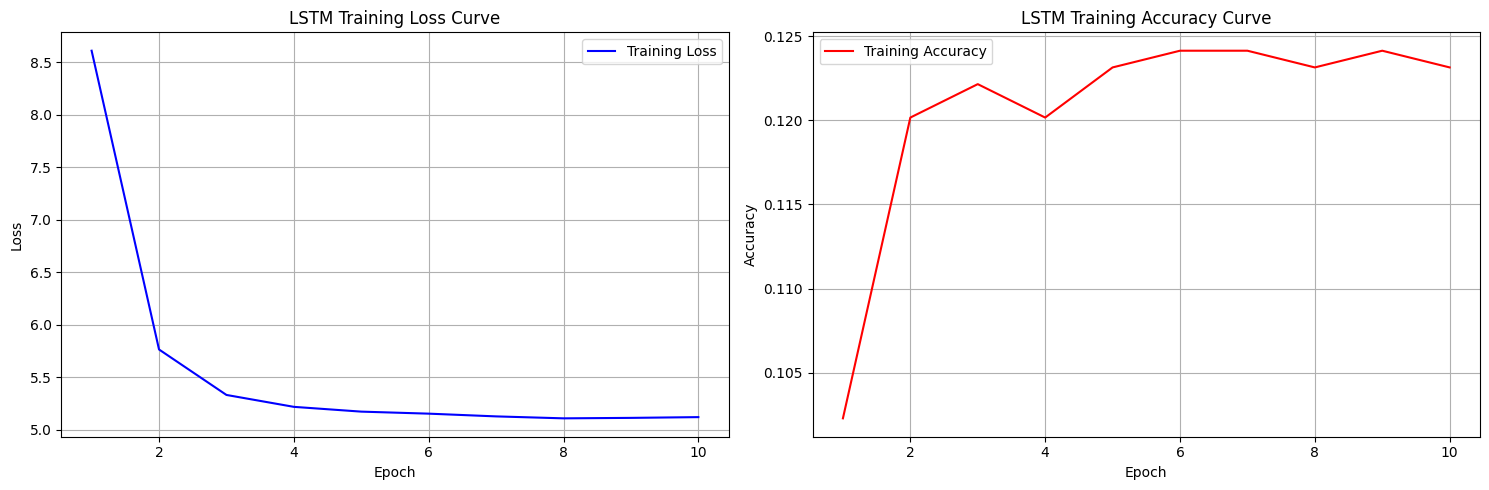

Learning curves saved to lstm_learning_curves.png
Evaluating model on data/test.txt...
Loaded 649918 texts from data/test.txt
Preparing training sequences...
Created 1003 training sequences



RNN 模型測試結果
測試損失 (Test Loss): 7.0105
測試準確率 (Test Accuracy): 0.1356 (13.56%)
測試困惑度 (Test Perplexity): 1108.1842
Testing incomplete sentence completion...

RNN 模型文本補全結果
輸入: cover with
補全: cover with skewers roll 1
--------------------------------------------------
輸入: roll up
補全: roll up cup lightly in
--------------------------------------------------
輸入: cook the
補全: cook the 1 about once
--------------------------------------------------
輸入: stir in
補全: stir in
--------------------------------------------------
輸入: spread out
補全: spread out of cook
--------------------------------------------------
輸入: transfer the
補全: transfer the
--------------------------------------------------
輸入: put the
補全: put the <UNK>
--------------------------------------------------
輸入: push the
補全: push the high
--------------------------------------------------
輸入: cut into
補全: cut into until a
--------------------------------------------------
輸入: toss the
補全: toss the 4 with
---------------------------

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 超參數
HIDDEN_DIM = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 32
SEQ_LENGTH = 10

# 載入數據
train_texts = load_data('data/train.txt')

# 建立詞彙表
vocab = Vocabulary()
vocab.build_vocab(train_texts, min_freq=3)

# 創建數據集
train_dataset = TextDataset(train_texts, vocab, SEQ_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 創建模型
model = LSTMLanguageModel(
    vocab_size=len(vocab),
    embed_dim=HIDDEN_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# 創建訓練器
trainer = LSTMTrainer(model, vocab, device)

# 訓練模型
print("Starting training...")

# 創建 epoch 進度條
epoch_pbar = tqdm(range(NUM_EPOCHS), desc="LSTM Training Progress")

for epoch in epoch_pbar:
    start_time = time.time()
    
    train_loss, train_accuracy = trainer.train_epoch(train_dataloader)
    
    epoch_time = time.time() - start_time
    
    # 更新 epoch 進度條
    epoch_pbar.set_postfix({
        'Loss': f'{train_loss:.4f}',
        'Acc': f'{train_accuracy:.4f}',
        'Time': f'{epoch_time:.1f}s'
    })
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Time: {epoch_time:.2f}s')
    

# 保存模型
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'hyperparameters': {
        'vocab_size': len(vocab),
        'embed_dim': HIDDEN_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS
    }
}, 'lstm_model.pth')

print("Model saved to lstm_model.pth")

# 繪製學習曲線
trainer.plot_learning_curves('lstm_learning_curves.png')

# 在測試數據上評估模型
evaluate_on_test_data(trainer, vocab, 'data/test.txt', SEQ_LENGTH, BATCH_SIZE)

# 測試不完整句子補全
test_incomplete_sentences(trainer, 'data/incomplete.txt')